## References:

- http://stanleybak.com/papers/li2020formats.pdf
- https://mediatum.ub.tum.de/doc/1287517/

## Example: Brusselator

In [1]:
using LazySets
using LazySets: center
using ForwardDiff
using Symbolics
using Plots
using Symbolics: jacobian, hessian
using IntervalArithmetic

┌ Info: Precompiling LazySets [b4f0291d-fe17-52bc-9479-3d1a343d9043]
└ @ Base loading.jl:1317
┌ Info: Precompiling ForwardDiff [f6369f11-7733-5829-9624-2563aa707210]
└ @ Base loading.jl:1317
┌ Info: Precompiling Symbolics [0c5d862f-8b57-4792-8d23-62f2024744c7]
└ @ Base loading.jl:1317


Let $x' = f(x)$ with state vector $x(t) \in \mathbb{R}^n$ and vector field $f : \mathbb{R}^n \to \mathbb{R}^n$.

Let $x^* \in \mathbb{R}^n$ be the linearization point.

$$
x_i' \in f_i(x^*) + \dfrac{\partial f_i(x)}{\partial x}_{\vert x = x^*}(x - x^*) + \dfrac{1}{2}(x - x^*)^T\dfrac{\partial^2 f_i(\xi)}{\partial x^2} (x - x^*)
$$

If we fix $x$ and $x^*$, then the Lagrange remainder can take any value resulting from $\xi \in \{x^* + \alpha (x - x^*), \alpha \in [0, 1] \}$.

Let $J \in \mathbb{R}^{n \times n}$ be the Jacobian matrix of the system $x' = f(x)$.

Then, $J_{ij}(x) = \dfrac{\partial f_i(x)}{\partial x_j}$.

Let $H_k$ be the Hessian matrix associated to the $k$-th component of the vector field $f$.

Then $H_k \in \mathbb{R}^{n\times n}$ such that $(H_k)_{ij} = \dfrac{\partial^2 f_{k}}{\partial x_i \partial x_j}$.

--

In [69]:
var = @variables x y
var = [x, y]

# ∂t = Differential(t)
# vector field (rhs)
f = [1 + log(x^2*y) - 0.5x, 1.5x - x^2*y]

X0 = Hyperrectangle(low=[0.8, 0.0], high=[1.0, 0.2]);
c = center(X0)

J = jacobian(f, var)

2×2 Matrix{Num}:
 (2//1)*(x^-1) - 0.5             y^-1
                 1.5 - (2x*y)  -(x^2)

In [9]:
H1 = hessian(f[1], var)

2×2 Matrix{Num}:
 2y  2x
 2x   0

In [10]:
H2 = hessian(f[2], var)

2×2 Matrix{Num}:
 -2y  -2x
 -2x    0

In [16]:
B0 = convert(IntervalBox, X0)

#H2[1, 1](B0)

[0.8, 1] × [0, 0.200001]

In [21]:
c

2-element Vector{Float64}:
 0.9
 0.1

In [22]:
J

2×2 Matrix{Num}:
 2x*y - 0.5              x^2
        1.5 - (2x*y)  -(x^2)

In [29]:
J[1, 1]

2x*y - 0.5

2-element Vector{Tuple{Num, Float64}}:
 (x, 0.9)
 (y, 0.1)

In [42]:
using ReachabilityAnalysis

┌ Info: Precompiling ReachabilityAnalysis [1e97bd63-91d1-579d-8e8d-501d2b57c93f]
└ @ Base loading.jl:1317


In [43]:
dict = [vi => ci for (vi, ci) in zip(var, c)] # ??

A = substitute.(J, Ref(dict))

fc = substitute.(f, Ref(dict))
b = fc - A*c;

In [44]:
dict_X0 = [vi => bi for (vi, bi) in zip(var, B0)] # ??

2-element Vector{Pair{Num, IntervalArithmetic.Interval{Float64}}}:
 x => [0.8, 1]
 y => [0, 0.200001]

In [53]:
M = substitute.(H1, Ref(dict_X0))
v = var - c # var = [x, y]
z = 1/2 * v' * M * v
hh1 = substitute(z, dict_X0)

M = substitute.(H2, Ref(dict_X0))
z = 1/2 * v' * M * v
hh2 = substitute(z, dict_X0);

In [54]:
hh1

[-0.0600001, 0.0600001]

In [55]:
hh2

[-0.0600001, 0.0600001]

In [58]:
U = IntervalBox(hh1.val, hh2.val)
U = convert(Hyperrectangle, U)

Hyperrectangle{Float64, StaticArrays.SVector{2, Float64}, StaticArrays.SVector{2, Float64}}([0.0, 0.0], [0.06000000000000001, 0.06000000000000001])

In [66]:
B = Matrix(1.0I, 2, 2)

Aval = [v.val for v in A]
bval = [v.val for v in b]

prob = @ivp(x' = Aval*x + bval + B*u, x(0) ∈ X0, x ∈ Universe(2), u ∈ U);

In [67]:
sol = solve(prob, T=0.5, alg=GLGM06(δ=0.1));

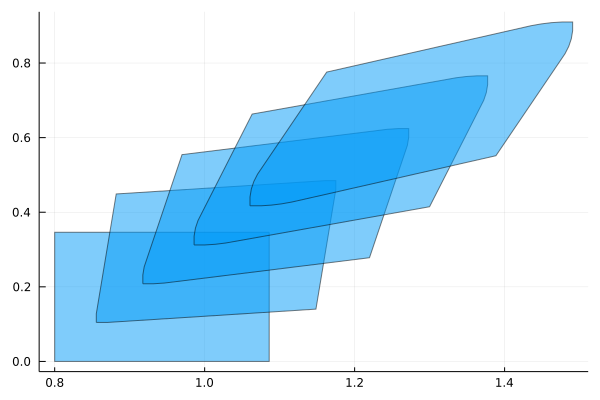

In [70]:
plot(sol, vars=(1, 2))

In [ ]:

z = t + t^2
D(z) # symbolic representation of derivative(t + t^2, t)
expand_derivatives(D(z)) # 1 + 2t

Symbolics.jacobian([x + x*y, x^2 + y],[x, y])

#2×2 Matrix{Num}:
# 1 + y  x
#    2x  1

B = simplify.([t^2 + t + t^2  2t + 4t
              x + y + y + 2t  x^2 - x^2 + y^2])

#2×2 Matrix{Num}:
#   t + 2(t^2)   6t
# x + 2(t + y)  y^2

simplify.(substitute.(B, (Dict(x => y^2),)))

#2×2 Matrix{Num}:
#     t + 2(t^2)   6t
# y^2 + 2(t + y)  y^2

substitute.(B, (Dict(x => 2.0, y => 3.0, t => 4.0),))

#2×2 Matrix{Num}:
# 36.0  24.0
# 16.0   9.0